In [4]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as f

spark = SparkSession.builder.master("yarn").getOrCreate()

## Utils

In [17]:
def extract_target_partners(interaction):
    """Extract all partners of a given target."""
    allInteractions = (
        interaction.filter(f.col("sourceDatabase") == "intact")
        .filter(f.col("scoring") > 0.42)
        .filter(f.col("targetB").isNotNull())
        .select("targetA", "targetB")
        .distinct()
    )
    return (
        allInteractions.union(
            allInteractions.select(
                f.col("targetA").alias("targetB"), f.col("targetB").alias("targetA")
            )
        )
        .distinct()
        .groupBy("targetA")
        .agg(f.count("targetB").alias("partners"))
        .withColumn(
            "partnersBin",
            f.when(f.col("partners") > 20, f.lit("greaterThan20"))
            .when(
                (f.col("partners") > 10) & (f.col("partners") <= 20),
                f.lit("from11to20"),
            )
            .when(
                (f.col("partners") > 0) & (f.col("partners") <= 10), f.lit("from1to10")
            )
            .otherwise(f.lit("none")),
        )
        .select(f.col("targetA").alias("targetId"), f.col("partnersBin"))
    )

## Analysis

In [47]:
targets_path = "gs://open-targets-pre-data-releases/24.06/output/etl/parquet/targets"

toxic_genes = (
    spark.read.parquet(targets_path)
    .filter(f.col("safetyLiabilities").isNotNull())
    .select(f.col("id").alias("targetId"), f.explode("safetyLiabilities").alias("safetyEvidence"))
    .filter(f.col("safetyEvidence.datasource") == "PharmGKB")
    .groupBy("targetId").agg(f.collect_set(f.col("safetyEvidence.event")).alias("pgx_events"))
)

print(f"{toxic_genes.count()} genes with toxicity from PGx")
toxic_genes.show()

541 genes with toxicity from PGx
+---------------+--------------------+
|       targetId|          pgx_events|
+---------------+--------------------+
|ENSG00000001084|[a drug hypersens...|
|ENSG00000001626|    [adverse events]|
|ENSG00000002016|[grade 3-4 neutro...|
|ENSG00000004809|[neutropenia and ...|
|ENSG00000004846|[haloperidol-indu...|
|ENSG00000005156|[grade 3-4 neutro...|
|ENSG00000005421|[cardiovascular s...|
|ENSG00000005471|    [cardiotoxicity]|
|ENSG00000006638|[aspirin-intolera...|
|ENSG00000007171|[Toxic liver dise...|
|ENSG00000007933|    [cardiotoxicity]|
|ENSG00000010310|[weight gain, pla...|
|ENSG00000011523|[aspirin-intolera...|
|ENSG00000012061|[vomiting, anemia...|
|ENSG00000014824|            [asthma]|
|ENSG00000015532|  [thrombocytopenia]|
|ENSG00000019186|    [nephrotoxicity]|
|ENSG00000023839|[skin rash, hepat...|
|ENSG00000025434|[cardiovascular e...|
|ENSG00000025708|[drug toxicity an...|
+---------------+--------------------+
only showing top 20 rows



In [121]:
# Most target annotation
prioritisation_path = "gs://open-targets-pre-data-releases/24.06/output/etl/parquet/targetPrioritisation"
prioritisation_df = spark.read.parquet(prioritisation_path)

# Target partners
interactions_path = "gs://open-targets-pre-data-releases/24.06/output/etl/parquet/interaction"
interactions_df = extract_target_partners(spark.read.parquet(interactions_path))

# Negative outcome in clinical trials
negative_stopped = (
    spark.read.parquet("gs://open-targets-pre-data-releases/24.06/output/etl/parquet/evidence/sourceId=chembl")
    .select("targetId", f.explode("studyStopReasonCategories").alias("reason"))
    .filter(f.col("reason") == "Negative").select("targetId", f.lit(1.0).alias("negativeClinicalTarget")).distinct()
)

annotated_genes = (
    # start off with all protein coding genes
    prioritisation_df.join(
        spark.read.parquet(targets_path).filter(f.col("biotype") == "protein_coding").selectExpr("id as targetId"),
        "targetId"
    )
    .withColumn("hasTEP", f.coalesce(f.col("hasTEP"), f.lit(0.0)))
    .join(toxic_genes, "targetId", "left")
    .withColumn("isToxic", f.when(f.col("pgx_events").isNull(), f.lit(0)).otherwise(f.lit(1))).drop("pgx_events")
    .join(interactions_df, "targetId", "left")
    .withColumn("molecularInteractors", f.coalesce(f.col("partnersBin"), f.lit("none"))).drop("partnersBin")
    .join(
        negative_stopped, "targetId", "left"
    )
    .withColumn("negativeClinicalTarget", f.coalesce(f.col("negativeClinicalTarget"), f.lit(0.0)))
    .persist()
)

annotated_genes.show()

+---------------+------------+----------+--------------+---------+---------+----------------------+--------------------+----------------------------+----------------------------------+------------------+------+-------------------+----------------------------+---------------------+-----------------+------------------+-------+--------------------+----------------------+
|       targetId|isInMembrane|isSecreted|hasSafetyEvent|hasPocket|hasLigand|hasSmallMoleculeBinder|   geneticConstraint|paralogMaxIdentityPercentage|mouseOrthologMaxIdentityPercentage|isCancerDriverGene|hasTEP|       mouseKOScore|hasHighQualityChemicalProbes|maxClinicalTrialPhase|tissueSpecificity|tissueDistribution|isToxic|molecularInteractors|negativeClinicalTarget|
+---------------+------------+----------+--------------+---------+---------+----------------------+--------------------+----------------------------+----------------------------------+------------------+------+-------------------+----------------------------

In [120]:
spark.read.parquet("gs://open-targets-pre-data-releases/24.06/output/etl/parquet/evidence/sourceId=chembl").select(f.explode("studyStopReasonCategories")).distinct().show()

+--------------------+
|                 col|
+--------------------+
|   Study staff moved|
|Business or admin...|
|          Regulatory|
|          No context|
|Insufficient enro...|
|   Insufficient data|
|             Success|
|       Uncategorised|
|Logistics or reso...|
|            COVID-19|
|        Study design|
|    Interim analysis|
|Safety or side ef...|
|            Negative|
|      Invalid reason|
|       Another study|
+--------------------+



array([[<Axes: title={'center': 'eventsCount'}>]], dtype=object)

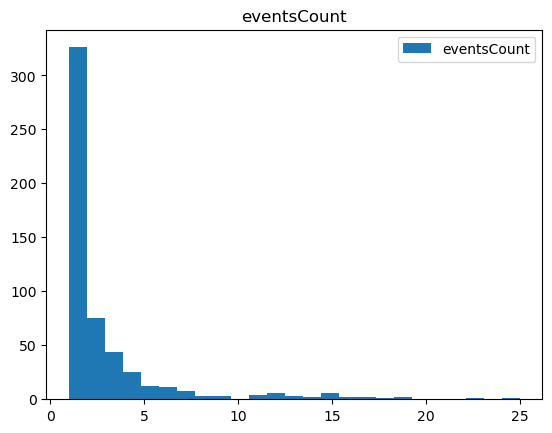

In [36]:
annotated_genes.select(f.size("pgx_events").alias("eventsCount"), "targetId").toPandas().hist(legend=True, grid=False, range=(1, 25), bins=25)

# Enrichment between targets with toxicity and their properties

In [123]:
import pandas as pd

all_data = annotated_genes.toPandas()
all_data = pd.get_dummies(all_data, columns=['molecularInteractors', 'maxClinicalTrialPhase', 'tissueSpecificity', 'tissueDistribution'], dtype=float)
toxic_data = all_data[all_data["isToxic"] == 1.0]
non_toxic_data = all_data[all_data["isToxic"] == 0.0]

print(toxic_data.shape)
print(non_toxic_data.shape)

(538, 32)
(19544, 32)


In [101]:
## Continuous variables

import pandas as pd
from scipy.stats import ttest_ind, mannwhitneyu

continuous_columns = ['geneticConstraint', 'mouseKOScore', 'paralogMaxIdentityPercentage', 'mouseOrthologMaxIdentityPercentage']

continuous_results = []
for column in continuous_columns:
    subset_toxic = toxic_data[column].dropna()
    subset_non_toxic = non_toxic_data[column].dropna()
    # Perform t-test (assuming normal distribution) and Mann-Whitney U test
    t_stat, t_p_val = ttest_ind(subset_toxic, subset_non_toxic, equal_var=False)
    # mw_stat, mw_p_val = mannwhitneyu(subset_toxic, subset_non_toxic, alternative='two-sided')
    
    continuous_results.append({
        'Property': column,
        't-test Statistic': t_stat,
        'p-value': t_p_val,
        # 'Mann-Whitney U Statistic': mw_stat,
        # 'Mann-Whitney U p-value': mw_p_val
    })

continuous_results_df = pd.DataFrame(continuous_results).dropna()
continuous_results_df


,Property,t-test Statistic,p-value
0,geneticConstraint,-3.680771,2.549879e-04
1,mouseKOScore,-8.954587,8.055302e-18
2,paralogMaxIdentityPercentage,1.900035,5.801292e-02
3,mouseOrthologMaxIdentityPercentage,-0.570534,5.685541e-01


In [124]:
## Categorical variables

import pandas as pd
from scipy.stats import fisher_exact

categorical_columns = [
    'isInMembrane', 'isSecreted', 'hasSafetyEvent', 'hasPocket', 'hasLigand',
    'hasTEP', 'hasHighQualityChemicalProbes', 'molecularInteractors_from11to20',
    'molecularInteractors_from1to10', 'molecularInteractors_greaterThan20', 'molecularInteractors_none',
    'maxClinicalTrialPhase_0.25', 'maxClinicalTrialPhase_0.5', 'maxClinicalTrialPhase_0.75', 'maxClinicalTrialPhase_1.0',
    'tissueSpecificity_-1.0', 'tissueSpecificity_0.5', 'tissueSpecificity_0.75', 'tissueSpecificity_1.0',
    'tissueDistribution_0.0', 'tissueDistribution_-1.0', 'tissueDistribution_0.5', 'tissueDistribution_1.0',
    "negativeClinicalTarget"
    ]

def create_contingency_table(df, property_col, target_col='isToxic'):
    table = [[0, 0], [0, 0]]
    table[0][0] = len(df[(df[property_col] == 1) & (df[target_col] == 1)])
    table[0][1] = len(df[(df[property_col] == 0) & (df[target_col] == 1)])
    table[1][0] = len(df[(df[property_col] == 1) & (df[target_col] == 0)])
    table[1][1] = len(df[(df[property_col] == 0) & (df[target_col] == 0)])
    return table

categorical_results = []
for column in categorical_columns:
    contingency_table = create_contingency_table(all_data, column)
    odds_ratio, p_value = fisher_exact(contingency_table)
    
    categorical_results.append({
        'Property': column,
        'Odds Ratio': odds_ratio,
        'p-value': p_value
    })

categorical_results_df = pd.DataFrame(categorical_results).dropna()
categorical_results_df


,Property,Odds Ratio,p-value
0,isInMembrane,1.834541,1.079534e-09
1,isSecreted,1.400393,1.339262e-02
3,hasPocket,5.007064,1.216872e-34
4,hasLigand,6.479160,1.302425e-82
5,hasTEP,0.908007,1.000000e+00
6,hasHighQualityChemicalProbes,0.881138,5.365507e-01
7,molecularInteractors_from11to20,1.309187,4.632884e-02
8,molecularInteractors_from1to10,1.210113,3.136647e-02
9,molecularInteractors_greaterThan20,1.256090,7.181978e-02
10,molecularInteractors_none,0.605937,5.794214e-07


In [125]:
all_results = (
    pd.concat([categorical_results_df, continuous_results_df])
    .assign(significant=lambda x: x["p-value"] < 0.05)
    .sort_values(by=["Property"], ascending=True)
)
all_results
# extract confidence intervals

# safety stopped trials add

,Property,Odds Ratio,p-value,t-test Statistic,significant
0,geneticConstraint,NaN,2.549879e-04,-3.680771,True
6,hasHighQualityChemicalProbes,0.881138,5.365507e-01,NaN,False
4,hasLigand,6.479160,1.302425e-82,NaN,True
3,hasPocket,5.007064,1.216872e-34,NaN,True
5,hasTEP,0.908007,1.000000e+00,NaN,False
0,isInMembrane,1.834541,1.079534e-09,NaN,True
1,isSecreted,1.400393,1.339262e-02,NaN,True
11,maxClinicalTrialPhase_0.25,0.000000,1.000000e+00,NaN,False
12,maxClinicalTrialPhase_0.5,3.271709,1.943491e-06,NaN,True
13,maxClinicalTrialPhase_0.75,4.936499,4.106444e-10,NaN,True


In [126]:
all_data[all_data["maxClinicalTrialPhase_1.0"] == 1].query("isToxic == 1.0")

,targetId,isInMembrane,isSecreted,hasSafetyEvent,hasPocket,hasLigand,hasSmallMoleculeBinder,geneticConstraint,paralogMaxIdentityPercentage,mouseOrthologMaxIdentityPercentage,...,maxClinicalTrialPhase_0.75,maxClinicalTrialPhase_1.0,tissueSpecificity_-1.0,tissueSpecificity_0.5,tissueSpecificity_0.75,tissueSpecificity_1.0,tissueDistribution_-1.0,tissueDistribution_0.0,tissueDistribution_0.5,tissueDistribution_1.0
131,ENSG00000077782,1.0,0.0,-1.0,1.0,1.0,1.0,-0.870285,-0.291362,0.908760,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
262,ENSG00000104687,0.0,0.0,-1.0,1.0,1.0,1.0,-0.002917,0.000000,0.042145,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
385,ENSG00000114200,0.0,1.0,-1.0,1.0,1.0,1.0,0.479579,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
406,ENSG00000143839,0.0,1.0,-1.0,1.0,1.0,1.0,0.062096,0.000000,0.000000,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
482,ENSG00000043591,1.0,0.0,-1.0,0.0,1.0,1.0,0.644613,0.000000,0.517820,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19401,ENSG00000184845,1.0,0.0,-1.0,0.0,1.0,1.0,-0.745780,0.000000,0.551570,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
19748,ENSG00000196689,1.0,0.0,-1.0,0.0,1.0,1.0,0.213482,0.000000,0.344460,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
19804,ENSG00000147246,1.0,0.0,-1.0,0.0,1.0,1.0,-0.053657,0.000000,0.530570,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
19864,ENSG00000115353,1.0,0.0,-1.0,1.0,1.0,1.0,-0.005314,0.000000,0.729730,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
